### NOTE: Search for "### FILL IN ###" to find areas of problem that you are expected to work on.

I discussed almost every question with my teammates and Jiaqi He

In [1]:
import cv2
import numpy as np
import urllib.request
from google.colab.patches import cv2_imshow

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import random
import os
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms

#seed everything for reproducability
def seed_everything(seed=1234):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.backends.cudnn.deterministic = True
seed_everything()


# **PART A: CNN [70 POINTS]**

**Q1: CNN basics [30 POINTS]**


The convolution function takes in an image, a kernel, a stride, and a padding size, and returns the output of the convolution operation. The image and kernel are numpy arrays, where image is of shape (height, width, channels) and kernel is of shape (kernel_height, kernel_width, channels, num_filters). The stride and padding are integers that specify the stride size and padding size, respectively.

<br>

Note that this implementation will assume that the input image has a depth of channels and that the kernel has the same depth. 

<br>

Apply convolution operation on the input image with the specified kernel, stride, and padding.

It takes arguments

    - image: numpy array of shape (height, width, channels)
    - kernel: numpy array of shape (kernel_height, kernel_width, channels, num_filters)
    - stride: integer, the stride size
    - padding: integer, the padding size

and returns

    - numpy array of shape (output_height, output_width, num_filters)

In [3]:
def convolution(image, kernel, stride, padding):
    height, width, channels = image.shape
    kernel_height, kernel_width, _, num_filters = kernel.shape

    ### FILL IN ### [5 POINTS]
    # Calculate output shape
    output_height = int((height + padding + padding - kernel_height)/stride) + 1
    output_width = int((width + padding + padding - kernel_width)/stride) + 1

    ### FILL IN ### [5 POINTS]
    # Add padding to the image if any
    if padding > 0:
        image_padded = np.pad(image, ((padding, padding), (padding, padding), (0, 0)))
    else:
        image_padded = image

    ### FILL IN ### [10 POINTS]
    # Initialize output array
    output = np.zeros((output_height, output_width, num_filters))
    # Apply convolution
    for i in range(output_height):
      for j in range(output_width):
        for z in range(num_filters):
          height_start = i * stride
          height_end = height_start + kernel_height
          width_start = j * stride
          width_end = width_start + kernel_width

          sub_image = image_padded[height_start:height_end, width_start:width_end]
          output[i,j,z] = (sub_image * kernel[:, :, :, z]).sum()


    return output


In [4]:
# Download sample image from OpenCV repository
url = 'https://raw.githubusercontent.com/opencv/opencv/master/samples/data/board.jpg'
filename = 'sample_image.jpg'
urllib.request.urlretrieve(url, filename)

('sample_image.jpg', <http.client.HTTPMessage at 0x7fe249435b50>)

In [5]:
### you should see sample_image.jpg present

! ls

sample_data  sample_image.jpg


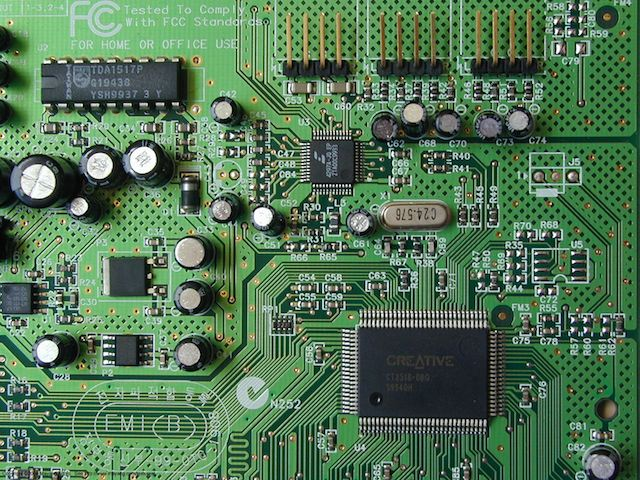

In [6]:
# Load sample image
image = cv2.imread('sample_image.jpg')
cv2_imshow(image)

In [7]:
image.shape

(480, 640, 3)

In [8]:
kernel_1 = np.zeros((3, 3, 3))

kernel_1[:,:,0] = kernel_1[:,:,1] = kernel_1[:,:,2] = np.array([[[1, 0, -1],
                                                                [1, 0, -1],
                                                                [1, 0, -1]]])

kernel_1 = kernel_1.reshape(3, 3, 3, 1)

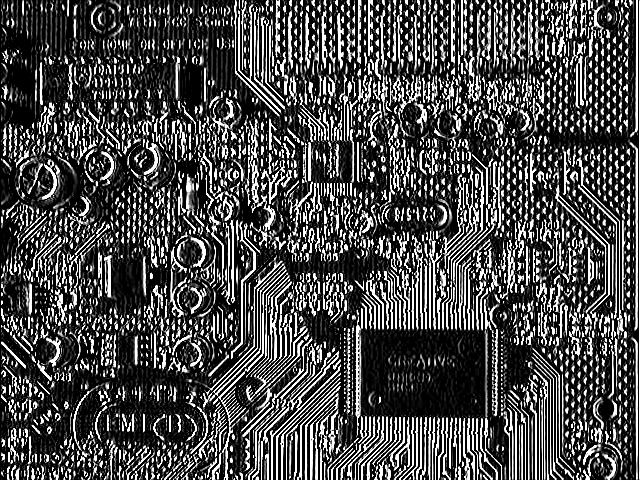

In [9]:
# Apply convolution with stride=1 and padding=1
output_1 = convolution(image, kernel_1, stride=1, padding=1)
cv2_imshow(output_1)

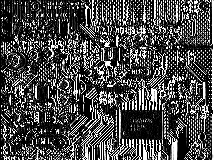

In [10]:
# Apply convolution with stride=3 and padding=1
output_1b = convolution(image, kernel_1, stride=3, padding=1)
cv2_imshow(output_1b)

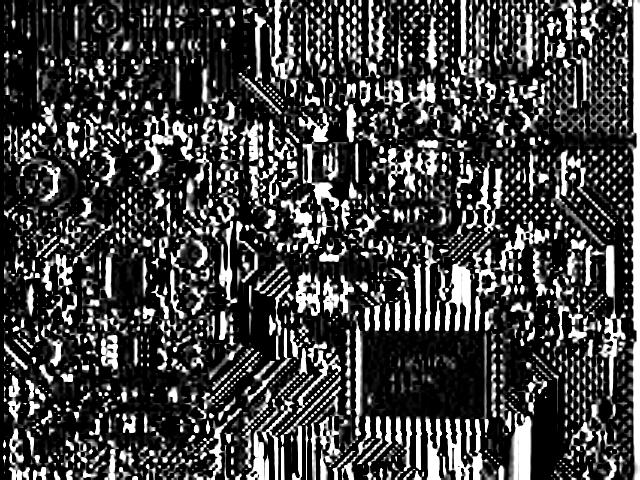

In [11]:
### restoring the size to see differences
output_1c = cv2.resize(output_1b, (image.shape[1], image.shape[0])) 
cv2_imshow(output_1c)

In [12]:
kernel_2 = np.zeros((3, 3, 3))

kernel_2[:,:,0] = kernel_2[:,:,1] = kernel_2[:,:,2] = np.array([[1, 1, 1],
                                                                [0, 0, 0],
                                                                [-1, -1, -1]])

kernel_2 = kernel_2.reshape(3, 3, 3, 1)

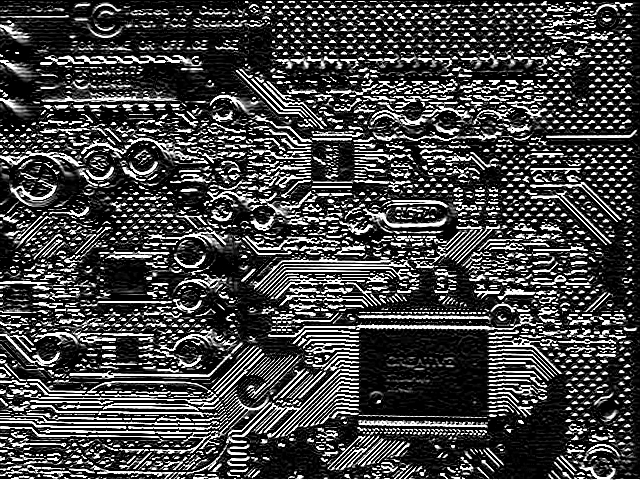

In [13]:
# Apply convolution with stride=1 and padding=1
output_2 = convolution(image, kernel_2, stride=1, padding=1)
cv2_imshow(output_2)

"### FILL IN ###" [3 POINTS]

What is the operation kernel_1 responsible for?

Answer: For kernel_1, we are tring to detect the horizontal edge, because the kernel is like: [[[1, 0, -1], [1, 0, -1], [1, 0, -1]]]

<hr>

"### FILL IN ###" [3 POINTS]

What is the operation kernel_2 responsible for?

Answer: For kernel_2, we are tring to detect the vertical edge, because the kernel is like: [[1, 1, 1], [0, 0, 0], [-1, -1, -1]]

<hr>

"### FILL IN ###" [4 POINTS]

As seen in output_1b and output_1c , what happens when we increase the stride value ? 

Answer: As we increase the stride, we can clearly see that the resolution of the image is decresing. That is because when we increase the stride, we are reducing the redundancy by skipping every "stride'th" input

<hr>


**Q2: CNN vs ANN [40 POINTS]**

Let's consider the MNIST dataset, which contains images of handwritten digits. Each image is 28 pixels wide and 28 pixels tall, for a total of 784 pixels. The task is to classify each image into one of ten possible classes (0-9).

<br>

In the Menu, change runtime type to GPU for faster computations

In [14]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [15]:
# Load MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor())

# Define data loaders
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=128, shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



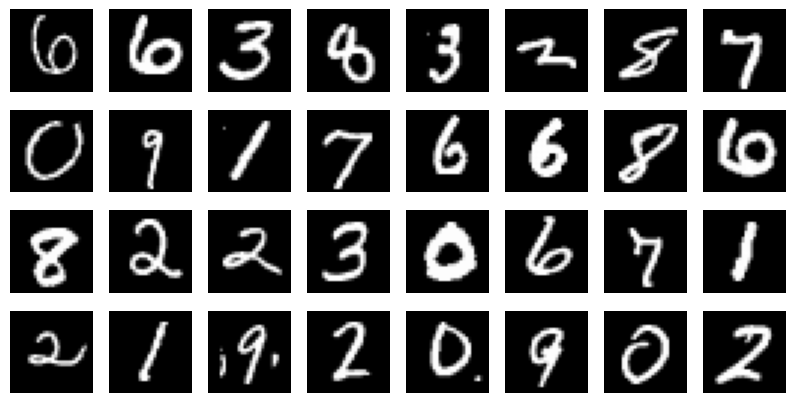

In [16]:
import matplotlib.pyplot as plt

# Get a batch of images from the data loader
images, labels = next(iter(train_loader))

# Plot the images
fig, axs = plt.subplots(4, 8, figsize=(10, 5))

for i in range(4):
    for j in range(8):
        axs[i, j].imshow(np.squeeze(images[i*8+j]), cmap='gray')
        axs[i, j].axis('off')

plt.show()

In [17]:
# Define the neural network model 
# Use single hidden layer of 128 nodes
# Use ReLU activation
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        ### FILL IN ### [5 POINTS]
        self.fc1 = nn.Linear(784, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        ### FILL IN ### [5 POINTS]
        x = x.view(-1, 28*28)
        # Pass the input through the layers
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        
        return x

# **I have two version of CNN**
version 1

In [18]:
# Define the convolutional neural network model 
# Use first convolution layer of 32 filters of size of 3x3 and a stride of 1
# Use second convolution layer of 64 filters of size of 3x3 and a stride of 1
# Use max pooling layer with kernel size of 2x2 and a stride of 2.
# Use single hidden layer of 128 nodes
# Use ReLU activation
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        ### FILL IN ### [10 POINTS]

        # layer 1
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1)
        self.batch1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # layer 2
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1)
        self.batch2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(64*5*5, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        ### FILL IN ### [5 POINTS]
        # conv 1
        x = self.conv1(x)
        x = self.batch1(x)
        x = self.relu1(x)

        # max pool 1
        x = self.pool1(x)

        # conv 2
        x = self.conv2(x)
        x = self.batch2(x)
        x = self.relu2(x)

        # max pool 2
        x = self.pool2(x)

        # x = x.view(-1, 64 * 7 * 7)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)

        return x

version 2

In [ ]:
# Define the convolutional neural network model 
# Use first convolution layer of 32 filters of size of 3x3 and a stride of 1
# Use second convolution layer of 64 filters of size of 3x3 and a stride of 1
# Use max pooling layer with kernel size of 2x2 and a stride of 2.
# Use single hidden layer of 128 nodes
# Use ReLU activation
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        ### FILL IN ### [10 POINTS]
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.linear = nn.Sequential(
            nn.LazyLinear(128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        ### FILL IN ### [5 POINTS]
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = self.linear(x)

        return x

In [19]:
# Initialize models and optimizer
neural_net = NeuralNet().to(device)
conv_net = ConvNet().to(device)
criterion = nn.CrossEntropyLoss()
neural_net_optimizer = optim.Adam(neural_net.parameters(), lr=0.001)
conv_net_optimizer = optim.Adam(conv_net.parameters(), lr=0.001)

In [20]:
# Train the neural network
for epoch in range(5):
    print("epoch = ",epoch)
    neural_net.train()
    for batch_idx, (data, targets) in enumerate(train_loader):
        data = data.to(device)
        targets = targets.to(device)

        # Forward pass
        neural_net_predictions = neural_net(data)
        neural_net_loss = criterion(neural_net_predictions, targets)

        # Backward pass
        neural_net_optimizer.zero_grad()
        neural_net_loss.backward()
        neural_net_optimizer.step()

    # Evaluate the neural network
    neural_net.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for data, targets in test_loader:
            data = data.to(device)
            targets = targets.to(device)
            neural_net_predictions = neural_net(data)
            _, predicted = torch.max(neural_net_predictions.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    print("test accuracy = ",correct/total)

epoch =  0
test accuracy =  0.9346
epoch =  1
test accuracy =  0.9533
epoch =  2
test accuracy =  0.964
epoch =  3
test accuracy =  0.9701
epoch =  4
test accuracy =  0.9713


In [21]:
# Train the convolutional neural network
for epoch in range(5):
    print("epoch = ",epoch)
    conv_net.train()
    for batch_idx, (data, targets) in enumerate(train_loader):
        data = data.to(device)
        targets = targets.to(device)

        # Forward pass
        conv_net_predictions = conv_net(data)
        conv_net_loss = criterion(conv_net_predictions, targets)

        # Backward pass
        conv_net_optimizer.zero_grad()
        conv_net_loss.backward()
        conv_net_optimizer.step()

    # Evaluate the conv neural network
    conv_net.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for data, targets in test_loader:
            data = data.to(device)
            targets = targets.to(device)
            conv_net_predictions = conv_net(data)
            _, predicted = torch.max(conv_net_predictions.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

    print("test accuracy = ",correct/total)

epoch =  0
test accuracy =  0.9836
epoch =  1
test accuracy =  0.9857
epoch =  2
test accuracy =  0.9865
epoch =  3
test accuracy =  0.9867
epoch =  4
test accuracy =  0.9902


Performing some lateral shifts in these images and see performance differences

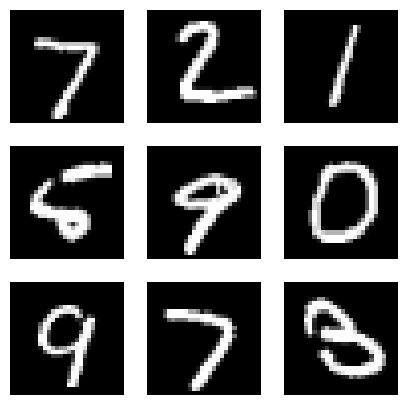

In [22]:
import matplotlib.pyplot as plt

# Get a batch of images from the data loader
images, labels = next(iter(test_loader))

# Plot the images
fig, axs = plt.subplots(3, 3, figsize=(5, 5))

for i in range(3):
    for j in range(3):
        axs[i, j].imshow(np.squeeze(images[i*8+j]), cmap='gray')
        axs[i, j].axis('off')

plt.show()

In [23]:
# Define the transformation
shifted_transform = transforms.Compose([
                    transforms.RandomAffine(degrees=0, translate=(0.2, 0.2)),
                    transforms.ToTensor(),
                ])

test_shifted_dataset = datasets.MNIST(root='./data', train=False, transform=shifted_transform)
test_shifted_loader = torch.utils.data.DataLoader(test_shifted_dataset, batch_size=128, shuffle=False)

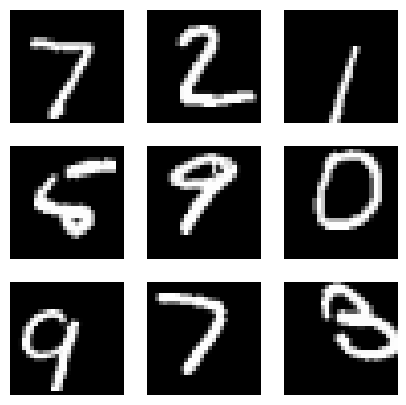

In [24]:
# Get a batch of images from the data loader
images, labels = next(iter(test_shifted_loader))

# Plot the images
fig, axs = plt.subplots(3, 3, figsize=(5, 5))

for i in range(3):
    for j in range(3):
        axs[i, j].imshow(np.squeeze(images[i*8+j]), cmap='gray')
        axs[i, j].axis('off')

plt.show()

In [25]:
neural_net.eval()
correct, total = 0, 0
with torch.no_grad():
    for data, targets in test_shifted_loader:
        data = data.to(device)
        targets = targets.to(device)
        neural_net_predictions = neural_net(data)
        _, predicted = torch.max(neural_net_predictions.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

print("test accuracy = ",correct/total)

test accuracy =  0.3122


In [26]:
conv_net.eval()
correct, total = 0, 0
with torch.no_grad():
    for data, targets in test_shifted_loader:
        data = data.to(device)
        targets = targets.to(device)
        conv_net_predictions = conv_net(data)
        _, predicted = torch.max(conv_net_predictions.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

print("test accuracy = ",correct/total)

test accuracy =  0.5683


Applying shifts of higher magnitude 

In [27]:
# Define the transformation
shifted_transform = transforms.Compose([
                    transforms.RandomAffine(degrees=0, translate=(0.4, 0.4)),
                    transforms.ToTensor(),
                ])

test_shifted_dataset = datasets.MNIST(root='./data', train=False, transform=shifted_transform)
test_shifted_loader = torch.utils.data.DataLoader(test_shifted_dataset, batch_size=128, shuffle=False)

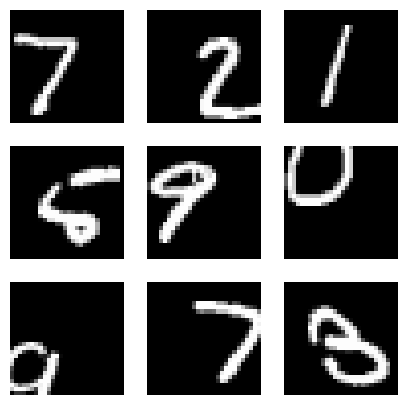

In [28]:
# Get a batch of images from the data loader
images, labels = next(iter(test_shifted_loader))

# Plot the images
fig, axs = plt.subplots(3, 3, figsize=(5, 5))

for i in range(3):
    for j in range(3):
        axs[i, j].imshow(np.squeeze(images[i*8+j]), cmap='gray')
        axs[i, j].axis('off')

plt.show()

In [29]:
neural_net.eval()
correct, total = 0, 0
with torch.no_grad():
    for data, targets in test_shifted_loader:
        data = data.to(device)
        targets = targets.to(device)
        neural_net_predictions = neural_net(data)
        _, predicted = torch.max(neural_net_predictions.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

print("test accuracy = ",correct/total)

test accuracy =  0.1354


In [30]:
conv_net.eval()
correct, total = 0, 0
with torch.no_grad():
    for data, targets in test_shifted_loader:
        data = data.to(device)
        targets = targets.to(device)
        conv_net_predictions = conv_net(data)
        _, predicted = torch.max(conv_net_predictions.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

print("test accuracy = ",correct/total)

test accuracy =  0.2421


"### FILL IN ###" [5 POINTS]

Report final performances of NN and CNN on basic MNIST test data. 

Answer: I have two version of CNN, the first version of CNN has slighly higher accuracy than the second version of CNN. And both of my CNN have higher accuracy than NN.

One of the final performance for NN is 0.1396 and CNN(version 1) is 0.2477, CNN(version 2) is 0.1818. CNN has higher accuracy than NN

<hr>

"### FILL IN ###" [5 POINTS]

Which one of the two models is better on shifted MNIST test data [2 POINTS] and why [3 POINTS] ?


Answer: I think CNN is better, because based on the final performances, it has higher accuracy than NN. I think is because we used two convolution layers and max pooling layer when we define the CNN model and forward function. Also, CNNs are good at looking for certain discriminative features occuring in any locations of an image. In this case, CNN is better.

<hr>

"### FILL IN ###" [5 POINTS]

We noted that the performance dropped when the images are shifted. In order to make the model more robust can we train the model on both the original and shifted images ?

Answer: I think yes, because when we train both the original and shifted images, our model can learn more feature and patterns of the shifted images. In this case, we can increase our accuracy. And is called data augmentation

<hr>


# **PART B: RNN [30 POINTS]**

**Q3: RNN vs LSTM [30 POINTS]**


In this example, we first load the Penn Treebank dataset using the imdb dataset from Keras. We then pad the sequences to a fixed length of 100 and build two models, one with a SimpleRNN layer and the other with an LSTM layer. 

We then train both models for 10 epochs using the RMSprop optimizer and binary cross-entropy loss function. After training, we evaluate the performance of both models on the test set using the evaluate method.


In [3]:
import tensorflow as tf 
from tensorflow.keras.layers import LSTM, SimpleRNN, Dense, Embedding
from tensorflow.keras.models import Sequential
# tf.set_random_seed(1234)
tf.random.set_seed(1234)
# Load the Penn Treebank dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.imdb.load_data(num_words=10000)

17464789/17464789 [==============================] - 0s 0us/step


In [4]:
# Get the word index dictionary
word_index = tf.keras.datasets.imdb.get_word_index()

# Reverse the word index dictionary
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

1641221/1641221 [==============================] - 0s 0us/step


Having a look at some samples

In [5]:
### 4th record in training data (integers are word indices)

print(x_train[4])

[1, 249, 1323, 7, 61, 113, 10, 10, 13, 1637, 14, 20, 56, 33, 2401, 18, 457, 88, 13, 2626, 1400, 45, 3171, 13, 70, 79, 49, 706, 919, 13, 16, 355, 340, 355, 1696, 96, 143, 4, 22, 32, 289, 7, 61, 369, 71, 2359, 5, 13, 16, 131, 2073, 249, 114, 249, 229, 249, 20, 13, 28, 126, 110, 13, 473, 8, 569, 61, 419, 56, 429, 6, 1513, 18, 35, 534, 95, 474, 570, 5, 25, 124, 138, 88, 12, 421, 1543, 52, 725, 6397, 61, 419, 11, 13, 1571, 15, 1543, 20, 11, 4, 2, 5, 296, 12, 3524, 5, 15, 421, 128, 74, 233, 334, 207, 126, 224, 12, 562, 298, 2167, 1272, 7, 2601, 5, 516, 988, 43, 8, 79, 120, 15, 595, 13, 784, 25, 3171, 18, 165, 170, 143, 19, 14, 5, 7224, 6, 226, 251, 7, 61, 113]


In [6]:
reverse_word_index[10]

'i'

In [7]:
# Decode the review text for this record
review_text = ' '.join([reverse_word_index.get(i - 3, '?') for i in x_train[4]])
review_text

"? worst mistake of my life br br i picked this movie up at target for 5 because i figured hey it's sandler i can get some cheap laughs i was wrong completely wrong mid way through the film all three of my friends were asleep and i was still suffering worst plot worst script worst movie i have ever seen i wanted to hit my head up against a wall for an hour then i'd stop and you know why because it felt damn good upon bashing my head in i stuck that damn movie in the ? and watched it burn and that felt better than anything else i've ever done it took american psycho army of darkness and kill bill just to get over that crap i hate you sandler for actually going through with this and ruining a whole day of my life"

In [8]:
len(review_text.split()), len(x_train[4])

(147, 147)

In [9]:
### corresponding label for 4th record in training data (0=negative,1=positive for movie reviews)
y_train[4]

0

In [10]:
### looking at a positive moview review 
y_train[400]

1

In [11]:
review_text = ' '.join([reverse_word_index.get(i - 3, '?') for i in x_train[400]])
review_text

"? in cold blood has to be ? as first rate movie making even if the subject matter is about as grim as it gets in the world of make believe but film noir fans should definitely find this one a gripping piece of work based as it is on a true life crime spree br br it opens with ? jones' music under the credits and ? dramatic views of a highway bus heading toward kansas city effectively setting the mood of the film even before the credits end the b w photography of conrad hall does a superb job right from the start br br also clear from the start robert blake and scott wilson are natural born actors they do a great job of portraying free spirited buddies looking for the next thrill ever see a millionaire ? in the electric hair hell no there are two kinds of rules in this world one for the rich and one for the poor says wilson taking a ? of alcohol behind the wheel br br both are destined to cross the path of a farm family showing no mercy and leaving no witnesses behind br br blake ? abo

In [12]:
# Pad the sequences to a fixed length
max_len = 100
x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train, maxlen=max_len)
x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test, maxlen=max_len)

In [14]:
from torch.nn.modules import activation
from keras.api._v2.keras import layers
# Build a SimpleRNN model
# Use an embedding layer with an output dimension of 128
# Use a single output layer with a sigmoid activation function
# Add optimizer and loss as mentioned above

### FILL IN ### [5 POINTS]
model_rnn = Sequential()
model_rnn.add(Embedding(input_dim=10000, output_dim=128, input_length=max_len))
model_rnn.add(SimpleRNN(units=128))
model_rnn.add(Dense(1, activation='sigmoid'))

model_rnn.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

# Train the SimpleRNN model
model_rnn.fit(x_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 40s 241ms/step - loss: 0.6412 - accuracy: 0.6133 - val_loss: 0.5503 - val_accuracy: 0.7108
Epoch 2/10
157/157 [==============================] - 27s 173ms/step - loss: 0.4489 - accuracy: 0.7998 - val_loss: 0.4411 - val_accuracy: 0.8036
Epoch 3/10
157/157 [==============================] - 29s 185ms/step - loss: 0.3838 - accuracy: 0.8388 - val_loss: 0.4229 - val_accuracy: 0.8178
Epoch 4/10
157/157 [==============================] - 28s 176ms/step - loss: 0.3461 - accuracy: 0.8584 - val_loss: 0.5522 - val_accuracy: 0.7676
Epoch 5/10
157/157 [==============================] - 27s 169ms/step - loss: 0.3239 - accuracy: 0.8683 - val_loss: 0.5704 - val_accuracy: 0.7570
Epoch 6/10
157/157 [==============================] - 26s 165ms/step - loss: 0.2961 - accuracy: 0.8823 - val_loss: 0.4380 - val_accuracy: 0.8192
Epoch 7/10
157/157 [==============================] - 27s 172ms/step - loss: 0.2837 - accuracy: 0.8898 - val_loss: 0.5767 - val_ac

In [15]:
# Build an LSTM model
# Use an embedding layer with an output dimension of 128
# Use a single output layer with a sigmoid activation function
# Add optimizer and loss as mentioned above

### FILL IN ### [5 POINTS]
model_lstm = Sequential([layers.Embedding(input_dim=10000, output_dim=128, input_length=max_len), 
                        # LSTM(units = 64),
                        LSTM(units = 128),
                        layers.Dense(1, activation='sigmoid')])
model_lstm.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

# Train the LSTM model
model_lstm.fit(x_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 70s 430ms/step - loss: 0.5723 - accuracy: 0.6876 - val_loss: 0.4446 - val_accuracy: 0.7932
Epoch 2/10
157/157 [==============================] - 69s 439ms/step - loss: 0.3641 - accuracy: 0.8443 - val_loss: 0.3913 - val_accuracy: 0.8350
Epoch 3/10
157/157 [==============================] - 72s 458ms/step - loss: 0.3047 - accuracy: 0.8746 - val_loss: 0.3700 - val_accuracy: 0.8334
Epoch 4/10
157/157 [==============================] - 74s 475ms/step - loss: 0.2663 - accuracy: 0.8946 - val_loss: 0.3502 - val_accuracy: 0.8456
Epoch 5/10
157/157 [==============================] - 81s 518ms/step - loss: 0.2358 - accuracy: 0.9093 - val_loss: 0.5479 - val_accuracy: 0.7946
Epoch 6/10
157/157 [==============================] - 86s 552ms/step - loss: 0.2157 - accuracy: 0.9201 - val_loss: 0.3819 - val_accuracy: 0.8378
Epoch 7/10
157/157 [==============================] - 83s 531ms/step - loss: 0.1956 - accuracy: 0.9251 - val_loss: 0.3701 - val_ac

"### FILL IN ###" [5 POINTS]

Report final performances of RNN and LSTM on IMDB validation data. 

Answer: When we set both unit to 128, we got for SimpleRNN: Epoch 10/10
157/157 [==============================] - 27s 170ms/step - loss: 0.2228 - accuracy: 0.9150 - val_loss: 0.5561 - val_accuracy: 0.8186

For LSTM, we got Epoch 10/10
157/157 [==============================] - 85s 545ms/step - loss: 0.1307 - accuracy: 0.9535 - val_loss: 0.4709 - val_accuracy: 0.8388

And LSTM has overall better performance than RNN

<hr>

"### FILL IN ###" [5 POINTS]

Which one of the two models is better on IMDB validation ?[2 POINTS] State one disadvantage of using LSTM over traditional RNN ? [3 POINTS]

Answer: Based on the performance, I think LSTM is better, because it has higher accuracy.

One disadvantage is that LSTM has more complex and expensive computation than traditional RNN. In this case, it may run slower on large dataset.

<hr>

"### FILL IN ###" [5 POINTS]

What is a Long Short-Term Memory (LSTM) network? [2 POINTS] How does it differ from a traditional RNN? [3 POINTS] 

Answer: LSTM can remembering information for long periods of time, it is capable of learning long-term dependencies. It learns when to update the hidden state by using a gating unit (to "selectively" remember or forget), it is useful for handling sequential dependencies in sequential data, e.g. speech recognition, handwriting recognition, and language translation

It is different from a traditional RNN, because it can learning long-term dependencies. Also the structure is different, LSTM need three gates to control the memory cell: the output gate, the input gate, and the forget gate. So that LSTM can choose which information to forget and which to remember.
<hr>

"### FILL IN ###" [5 POINTS]

What are Seq2Vec [2 POINTS], Vec2Seq [2 POINTS] and Seq2Seq [1 POINTS] models?

Answer: Seq2Vec is Sequence to Vector model. It takes a sequence of inputs and produce a fixed-length vector as output

Vec2Seq is Vector-to-Sequence model. It takes a fixed-length vector as input and generate a variable-length sequence as output.

Seq2Seq is Sequence-to-Sequence model. It takes a sequence of inputs and produce a sequence of outputs.